In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import decimal
import matplotlib.pyplot as plt
from scipy import interpolate as intp
from scipy import stats
import seaborn as sns
from itertools import compress
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import *
from scipy import signal
from scipy import stats
from scipy.signal import convolve as sig_convolve
from scipy.io import loadmat
from scipy.io import savemat
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import datajoint as dj
dj.config['database.host'] = 'at-database.ad.bcm.edu'
dj.config['database.user'] = 'raj'
dj.config['database.password'] = 'language-wonderful-joy-system'
dj.conn()

Connecting raj@at-database.ad.bcm.edu:3306


DataJoint connection (connected) raj@at-database.ad.bcm.edu:3306

In [3]:
from stimulus import stimulus
import datajoint as dj
tune=dj.create_virtual_module('tune','pipeline_tune')
GNN=dj.create_virtual_module('GNN', 'pipeline_GNN')
meso=dj.create_virtual_module('meso','pipeline_meso')

In [4]:
# define custom functions
def pick_indices(x,l,u):
    """
    Pick the elements of an array x that lie between l and u
    """
    id_s = np.nonzero(x >= l)[0]
    id_e = np.nonzero(x <= u)[0]
    return np.intersect1d(id_s,id_e)

def vonMisesFn(x,amp,scale,theta0):
    """
    Von Mises function, but for orientations
    x goes from (0, pi)
    """
    return amp*np.exp(scale*np.cos(2*(x-theta0)))

def expandN_dims(x,N):
    """
    Add N extra dimensions to x
    """
    dims = np.shape(x.shape)[0] 
    for i in range(N):
        x = np.expand_dims(x,axis=dims+i)
    return x

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [5]:
"""
Settings
"""
ExtractMovieReq = 0  #sync and arrange stimulus movie frames with the different stimulus conditions
savevars = 0         #save required variables as mat files - for e.g. orientation and contrast maps, neural responses
performfiltering = 1 #filter the neural responses
plotTuningCurves = 1
plotCorrFunctions = 1
normalizeByNNeu = 1  #normalize the neural projections for each population by the no. of neurons in that population

In [6]:
"""
Select Mouse ID
"""
#key = dict(animal_id=17797, session=6, scan_idx=8, segmentation_method=6)
key = dict(animal_id=18142, session=7, scan_idx=2, segmentation_method=6)

In [7]:
"""
Fetch the ground truth stimulus orientations and contrasts
Quantize these variables to compute tuning functions by binning
"""

Data = loadmat('./Platinum_mouse_data/OMap_VarmaTestPlatinum.mat')
OMapFull = Data['OMapFull']
# OMap is defined anti-clockwise and angle lines up with the stripes here.
# It takes values 0 to 255, corresponding to 0 to pi
# Vertical stripes correspond to an orientation of 0 or pi, horizontal stripes to pi/2

Data = loadmat('./Platinum_mouse_data/CMap_VarmaTestPlatinum.mat')
CMapFull = Data['CMapFull']
# CMap takes values 0 to 255, corresponding to 0 to 1

if ExtractMovieReq:
    Data  = loadmat('./Platinum_mouse_data/VMovie.mat')
    VMovie = Data['VMovie']

# Quantize OMap and CMap
Nbins_o = 8
Nbins_c = 3

OMapFull_q = np.uint8(np.floor(OMapFull*(Nbins_o/256.0)))
CMapFull_q = np.uint8(np.floor(CMapFull*(Nbins_c/256.0)))

Py, Px = OMapFull.shape[0:2] # Shape of one frame of OMap. Actual movie would be upsampled by 4
print('Size of OMap and CMap is',Py,'x',Px)
print('Size of stimulus movie is',Py*4,'x',Px*4)

Size of OMap and CMap is 28 x 48
Size of stimulus movie is 112 x 192


In [8]:
"""
Fetch the timing information
"""

# get the ms_delay for each neuron in the scan
delayinfo = (meso.ScanSet.UnitInfo() & key).fetch(dj.key, 'ms_delay',order_by='unit_id')
ms_delay = delayinfo[1]/1000

# get the frame_times. Frame_times corrrespond to the neural responses
trial_keys, depths = (meso.ScanInfo.Field() & key).fetch(dj.key,'z')
Ndepths = len(np.unique(depths))
print('Ndepths =', Ndepths)
trial_keys, frame_times = (stimulus.Sync() & key).fetch(dj.key, 'frame_times')
frame_times = frame_times[0].squeeze()[::Ndepths]
print('Size of frame_times =',np.shape(frame_times))
print('dt_frame =', np.mean(np.diff(frame_times)))

# get the flip times . Flip_times correspond to the stimulus movie
trial_keys, fliptimes = (stimulus.Trial() & key).fetch(dj.key, 'flip_times')
fliptimes = np.stack(fliptimes,axis=0).squeeze(axis=1)
print('Size of fliptimes =',fliptimes.shape)

Ndepths = 2
Size of frame_times = (55000,)
dt_frame = 0.08040124735517236
Size of fliptimes = (120, 1800)


In [9]:
""" 
fetch the neural responses
"""
trace_keys, traces = (meso.Activity.Trace() & key).fetch(dj.key, 'trace', order_by='unit_id')
traces = np.stack(traces,axis=0)
print('Shape of traces =',traces.shape)

NNeu = traces.shape[0]
print('No. of neurons in the scan =', NNeu)

Shape of traces = (4786, 55000)
No. of neurons in the scan = 4786


In [10]:
"""
Sync activity of all the neurons with the frame_times by accounting for ms_delay.
This is done using nearest neighbor interpolation
"""

dt = np.mean(np.diff(frame_times)) # time difference between successive frames
print('dt =',np.round(dt*10000)/10,'ms')
print('Scan sampling freq =',np.round(1000/dt)/1000,'Hz')

for k in range(NNeu):
    if ms_delay[k] >= dt/2:
        traces[k,1:] = traces[k,0:-1]

del dt, k

dt = 80.4 ms
Scan sampling freq = 12.438 Hz


In [11]:
"""
Fetch the receptive fields of the neurons.
RFs were computed using spike-triggered average. Only neurons with good RFs are fetched. 
"""

# get the STAs, estimated receptive field centers and the snr which quantifies the quality of the RF

tkeys, response_maps, rx, ry, snr = (tune.STA.Map() * tune.STAExtent() * tune.STAQual() 
                                     & key).fetch(dj.key, 'map','x','y', 'snr',order_by='unit_id')

print('No. of neurons in scan =',NNeu)
print('No. of neurons with estimated RF centers =',len(tkeys))

No. of neurons in scan = 4786
No. of neurons with estimated RF centers = 881


In [12]:
"""
Sort the neurons based on the quality of the RF
"""

# sort the neurons according to their snr
sortidx = np.argsort(-snr)
NNeu_sel = len(tkeys)
# sortidx = sortidx[-NNeu_sel:]

# record the unit_id, receptive field centers rx,ry for neurons
Unit_idVec = np.zeros([NNeu_sel],dtype='uint8')
RxVec = np.zeros([NNeu_sel])
RyVec = np.zeros([NNeu_sel])

for k in range(NNeu_sel):
    Unit_idVec[k] = tkeys[sortidx[k]]['unit_id']
    RxVec[k] = rx[sortidx[k]]
    RyVec[k] = ry[sortidx[k]]
    
# downsample by 4 to map the RFcenters to the ground truth orientation and contrast maps (the movie was upsampled by a factor of 4)
RxVec = np.round(RxVec/4.0)
RyVec = np.round(RyVec/4.0)


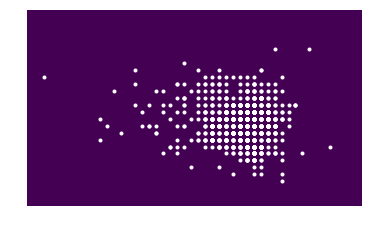

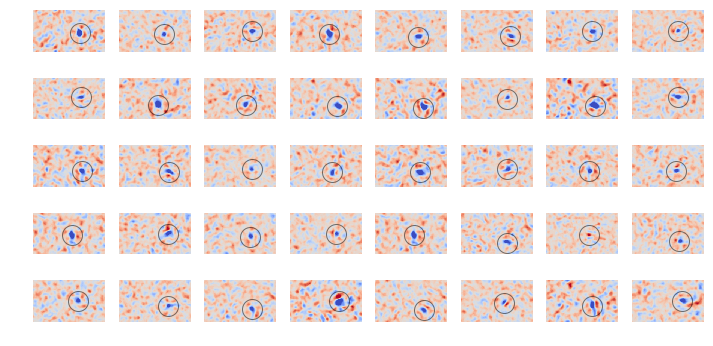

In [17]:
"""
Plot the RF centers and a few example RFs
"""

# Plot the RF centers
x,y = np.meshgrid(np.arange(0,Px),np.arange(0,Py))
plt.figure()
plt.imshow(np.zeros([Py,Px]))
plt.plot(RxVec,RyVec,'w.')
plt.axis('off')
plt.show()

# plot example RFs of a few neurons

# get bounds for response maps
MaxVec = np.zeros([NNeu_sel])
MinVec = np.zeros([NNeu_sel])
for i in range(NNeu_sel):
    MaxVec = np.max(response_maps[i])
    MinVec = np.min(response_maps[i])

plt.figure()
plt.subplots(5,8,figsize=(12,6))
for k in range(40):
    plt.subplot(5,8,k+1)
    plt.imshow(response_maps[sortidx[k]][:,:,1],cmap = 'coolwarm',vmin = np.min(MinVec),vmax=np.max(MaxVec))
    plt.plot(4*RxVec[k], 4*RyVec[k], 'ko', markersize=20,alpha=0.5,mfc="None")
    plt.axis('off')
plt.show()

In [18]:
"""
1. Retain only neurons for which RFs were computed 
2. Normalize the responses by the standard deviation of the non-zero bins
3. Filter the responses if necessary
"""

# 1. retain only neurons for which RFs were computed
traces = traces[Unit_idVec,:]
NNeu   = NNeu_sel

traces = np.round(traces*100)/100.0

# 2. normalize responses by the std of the non-zero bins (is this the right thing to do ?)
# for i in range(NNeu):
#     idx = np.nonzero(traces[i,:] != 0)
#     s = traces[i,idx].std()
#     traces[i,:] = traces[i,:]/s
# del s
    
# 3. filter the responses
b = np.hamming(5)
b = b/sum(b)

if performfiltering:
    traces = signal.filtfilt(b,1,traces,axis=1)

del i,b

In [19]:
"""
Fetch the order in which the various Varma clips were presented.  
"""

# First load the condition labels from mat files for the two repetitions of the stimulus
# Each condition corresponds to different stimulus parameters. Each condition was presented twice, but they were all randomly shuffled. 
# Each condition is 30s long. We have 40 Varma + 20 CM Trippy conditions presented twice -> a total of 120 clips each of length 30 s 
# Size of fliptimes is 120 x 1800 ==> 120 clips x (30s x 60fps)

Data = loadmat('./Platinum_mouse_data/idx1.mat')
Cidx1 = Data['idx1'].squeeze()-1 # condition label
Data = loadmat('./Platinum_mouse_data/idx2.mat')
Cidx2 = Data['idx2'].squeeze()-1 # condition label

aidx1 = np.argsort(Cidx1) # use these to match the two sets
aidx2 = np.argsort(Cidx2)

print('The order in which the stimulus conditions were presented:\n')
print(Cidx1)
print(Cidx2)
print('\n 0 to 39 correspond to Varma, 40 to 59 are CM Trippy')

The order in which the stimulus conditions were presented:

[31 39 21 33 34  5 54  2 15 10 53 29 44 59 50 32  6 37 57 41 27 16 40 46
 13 45 55  7 58  4 47 52 28 20 24 51 36 30 48 26 49 25 42 18 43 14  0 35
 22  1  3 17 23 38 12  8 19 56  9 11]
[38 31 30 58 51 35  7  8 54 40 44 16 52 13 17 11  1  9 46 25 42 39 15 20
 28 59 50 37 19  2 43 32 56  6 23 29 36 22 45 18 47 48  3 49  0 27 26 33
 41 12 55 21 10  4 53 24 14 34  5 57]

 0 to 39 correspond to Varma, 40 to 59 are CM Trippy


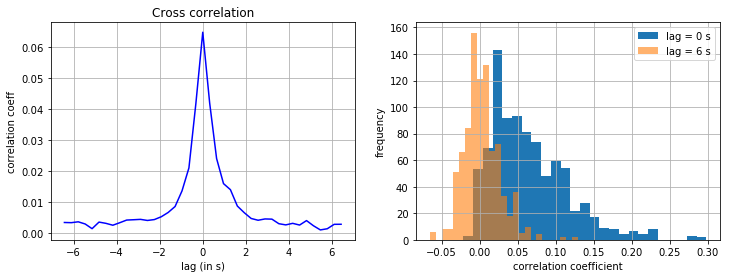

In [20]:
"""
In these Platinum mouse scans, each Varma and CMTrippy clip was shown twice to the mouse.
Compute the cross-correlation between responses to the two repeats.

1. z-score the responses (perhaps not necessary ?)
2. Find the number of samples of neural activity for each condition 
3. Choose the min of TVec as the number of samples for all conditions. 
4. Rearrange the responses into conditions
5. compute the cross correlations
6. Plot cross correlations

"""

# 1. z-score the responses
traces_z = stats.zscore(traces,axis=1)


Nc = fliptimes.shape[0] # no. of conditions
TVec = np.zeros(Nc)

# 2. Find the number of samples of neural activity for each condition 
for ii in range(Nc):
    TVec[ii] = len(pick_indices(frame_times,fliptimes[ii,0],fliptimes[ii,-1]))
    
# 3. Choose the min of TVec as the number of samples for all conditions. 
# So that we can arrange the responses in a matrix, to enable easier computation of correlations
T = int(np.min(TVec))

# 4. Rearrange the responses based on fliptimes of the conditions
traces_s = np.zeros([Nc,NNeu,T])
for ii in range(Nc):
    idx = pick_indices(frame_times,fliptimes[ii,0],fliptimes[ii,-1])[0:T]
    traces_s[ii,:,:] = traces_z[:,idx]



# 5. compute the cross correlations
Ntau = 20 # no. of time lags
Corr = np.zeros([int(Nc/2), NNeu, 2*Ntau+1]) #Nc/2 because there are 2 repetitions of each cond
F = 4 #no. of time samples for each lag. 1 samples corresponds to dt = 79.4 ms

for ii in range(int(Nc/2)):
    # pick the 2 sets of neural activity corresponding to the two conditions
    # here we are looking at the sequence of conditions from 0,1,2... 
    r1 = traces_s[aidx1[ii],:,:]
    r2 = traces_s[int(Nc/2)+aidx2[ii],:,:]
    
    #r1 = stats.zscore(r1)
    #r2 = stats.zscore(r2)

    for tau in range(-Ntau,Ntau+1):
        if tau < 0:
            Corr[ii,:,tau+Ntau] = np.mean(r1[:,-F*tau:]*r2[:,0:T+F*tau],axis=1)
        elif tau >= 0:
            Corr[ii,:,tau+Ntau] = np.mean(r1[:,0:T-F*tau]*r2[:,F*tau:],axis=1)

Corr = np.mean(Corr,axis=0)

# 6. Plot the cross correlations
dt = np.mean(np.diff(frame_times))
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(dt*F*np.arange(-Ntau,Ntau+1),np.mean(Corr,axis=0),'b')
ax[0].set(xlabel='lag (in s)', ylabel = 'correlation coeff', title = 'Cross correlation')
ax[0].grid('on')

ax[1].hist(Corr[:,20],25)
ax[1].hist(Corr[:,-1],25,alpha=0.6)
ax[1].set(xlabel='correlation coefficient',ylabel='frequency')
ax[1].legend(['lag = 0 s', 'lag = 6 s'])
ax[1].grid('on')

del traces_z, traces_s

In [21]:
"""
Separate the neural activity into different conditions.
And for each of these conditions, extract the orientation, contrast and stimulus movie and align them with the frametimes.
Separation into individual conditions and time sync is needed for further analysis --> computing tuning curves, constructing population responses, etc.

1. Arrange the responses according to the condition 
2. Arrange the neural activity such that the conditions are in natural order i.e., 0,1,2, ...
3. Next we will sync the stimulus with the frame times by nearest neighbor interpolation
4. Save required variables and clear variables

"""


# 1. Arrange the responses according to the condition 
traces_s = np.zeros([Nc,NNeu,T])
for ii in range(Nc):
    idx = pick_indices(frame_times,fliptimes[ii,0],fliptimes[ii,-1])[0:T]
    traces_s[ii,:,:] = traces[:,idx]
    

# 2. Arrange the neural activity such that the conditions are in natural order i.e., 0,1,2, ...
Nc_V  = 40 # No. of Varma conditions
Nreps = 2 # each condition was repeated twice 
spikesReq = np.zeros([Nreps,Nc_V,NNeu_sel,T])

for k in range(Nc_V):
    spikesReq[0,k,:,:] = traces_s[aidx1[k],:,:]
    spikesReq[1,k,:,:] = traces_s[aidx2[k] + 60,:,:]
    
del traces, traces_s

# 3. Next we will sync the stimulus with the frame times by nearest neighbor interpolation

OMapReq = np.zeros([Nreps,Nc_V,Py,Px,T],dtype='uint8')
CMapReq = np.zeros([Nreps,Nc_V,Py,Px,T],dtype='uint8')

if ExtractMovieReq:
    VMovieReq = np.zeros([Nreps,Nc_V,VMovie.shape[0],VMovie.shape[1],T],dtype='uint8')

OMapReq_U = np.zeros([Nreps,Nc_V,Py,Px,T],dtype='uint8') #not quantized
CMapReq_U = np.zeros([Nreps,Nc_V,Py,Px,T],dtype='uint8') #not quantized

for ii in range(Nc_V):
    
    fl_t0 = fliptimes[aidx1[ii],:]
    fl_t1 = fliptimes[aidx2[ii]+60,:] 
    #60 because the first 60 conditions include 40 Varma and 20 CM trippy
    
    id_str = np.nonzero(frame_times >= fl_t0[0])[0]
    id_end = np.nonzero(frame_times <= fl_t0[-1])[0]
    idx0 = np.intersect1d(id_str,id_end)
    idx0 = idx0[0:T]
    
    id_str = np.nonzero(frame_times >= fl_t1[0])[0]
    id_end = np.nonzero(frame_times <= fl_t1[-1])[0]
    idx1 = np.intersect1d(id_str,id_end)
    idx1 = idx1[0:T]

    # frame times for stimulus corresponding to these sessions
    fr_t0 = frame_times[idx0];
    fr_t1 = frame_times[idx1];

    fr_t0 = fr_t0 - fl_t0[0];
    fl_t0 = fl_t0 - fl_t0[0];
    
    fr_t1 = fr_t1 - fl_t1[0];
    fl_t1 = fl_t1 - fl_t1[0];
    

    # find nearest frame 
    for tt in range(T):
        # for rep 0
        idxa = np.nonzero(fl_t0 >= fr_t0[tt])[0]
        idxa = idxa[0]
        idxb = np.nonzero(fl_t0 < fr_t0[tt])[0]
        idxb = idxb[-1]
        da = fl_t0[idxa] - fr_t0[tt]
        db = fr_t0[tt] - fl_t0[idxb]
        if da <= db:
            idx = idxa
        else:
            idx = idxb
        OMapReq[0,ii,:,:,tt] = OMapFull_q[:,:,idx,ii]
        CMapReq[0,ii,:,:,tt] = CMapFull_q[:,:,idx,ii]
        OMapReq_U[0,ii,:,:,tt] = OMapFull[:,:,idx,ii]
        CMapReq_U[0,ii,:,:,tt] = CMapFull[:,:,idx,ii]
        if ExtractMovieReq:
            VMovieReq[0,ii,:,:,tt] = VMovie[:,:,idx,ii]
        
        # for rep 1
        idxa = np.nonzero(fl_t1 >= fr_t1[tt])[0]
        idxa = idxa[0]
        idxb = np.nonzero(fl_t1 < fr_t1[tt])[0]
        idxb = idxb[-1]
        da = fl_t1[idxa] - fr_t1[tt]
        db = fr_t1[tt] - fl_t1[idxb]
        if da <= db:
            idx = idxa
        else:
            idx = idxb
        OMapReq[1,ii,:,:,tt] = OMapFull_q[:,:,idx,ii]
        CMapReq[1,ii,:,:,tt] = CMapFull_q[:,:,idx,ii]
        OMapReq_U[1,ii,:,:,tt] = OMapFull[:,:,idx,ii]
        CMapReq_U[1,ii,:,:,tt] = CMapFull[:,:,idx,ii]
        if ExtractMovieReq:
            VMovieReq[1,ii,:,:,tt] = VMovie[:,:,idx,ii]
        
# 4. Save required variables and clear variables

if savevars:
    mdict1 = {'spikesReq': spikesReq}
    mdict2 = {'OMapReq':OMapReq_U, 'CMapReq':CMapReq_U}

    fname1 = './Platinum_mouse_GNN_data/spikes_' + str(key['animal_id']) + '_' + str(key['session']) + '_' + str(key['scan_idx']) + '.mat' 
    fname2 = './Platinum_mouse_GNN_data/groundtruth_parameters_' + str(key['animal_id']) + '_' + str(key['session']) + '_' + str(key['scan_idx']) + '.mat' 
    
    if ExtractMovieReq:
        mdict3 = {'VMovieReq': VMovieReq}
        fname3 = './Platinum_mouse_GNN_data/VarmaMovie_' + str(key['animal_id']) + '_' + str(key['session']) + '_' + str(key['scan_idx']) + '.mat'
        savemat(fname3, mdict3)
        del VMovie 

    savemat(fname1, mdict1)
    savemat(fname2, mdict2)
    
del OMapFull, OMapFull_q, CMapFull, CMapFull_q



In [22]:
"""
Use the local constrast and orientation features estimated from the movies instead of the generative parameters
"""

fname = './Platinum_mouse_GNN_data/EstimatedLocalFeatures_'+str(key['animal_id']) + '_' + str(key['session']) + '_' + str(key['scan_idx']) + '.mat'
Data = loadmat(fname)
CMapReq_U = Data['CMapReq']
OMapReq_U = Data['OMapReq']
del Data

# quantize the contrast and orientation maps
OMapReq = np.uint8(np.floor(OMapReq_U*(Nbins_o/256.0)))

CMapReq = np.uint8(np.floor(CMapReq_U*(5/256.0)))
idx = np.nonzero(CMapReq > 1)
CMapReq[idx] = 1

Nbins_c = 2

In [23]:
print(spikesReq.shape)
print(OMapReq.shape)

(2, 40, 881, 372)
(2, 40, 28, 48, 372)


In [24]:
nn = 0
px = np.int(RxVec[nn])
py = np.int(RyVec[nn])
print(OMapReq[:,:,py,px,:].shape)
print(CMapReq[:,:,py,px,:].shape)
print(spikesReq[:,:,nn,:].shape)

(2, 40, 372)
(2, 40, 372)
(2, 40, 372)


In [25]:
# Computing tuning curves

FS_All = np.zeros([NNeu, Nbins_o, Nbins_c])

BinCounts = np.zeros([NNeu, Nbins_o, Nbins_c])

for nn in range(NNeu):
    R_nn = spikesReq[:,:,nn,:].flatten()
    
    # receptive field centers of neuron nn
    px = np.int(RxVec[nn])
    py = np.int(RyVec[nn])
    
    for ii in range(Nbins_c):
        
        idx_c = np.nonzero(CMapReq[:,:,py,px,:].flatten() == ii)[0] #find indices where contrast = ii
        
        for jj in range(Nbins_o):
            
            idx_o = np.nonzero(OMapReq[:,:,py,px,:].flatten() == jj)[0] #find indices where orientation = jj
            idx_oc = np.intersect1d(idx_c, idx_o)  # intersection of contrast and orientation bin
            
            BinCounts[nn,jj,ii] = len(idx_oc)
            
            FS_All[nn,jj,ii] = np.sum(R_nn[idx_oc])

    
    

In [27]:
FS_All = FS_All/BinCounts

Plot has RF, tuning curve for high contrast bin (black) + fit, tuning curve for low contrast bin (red) +fit


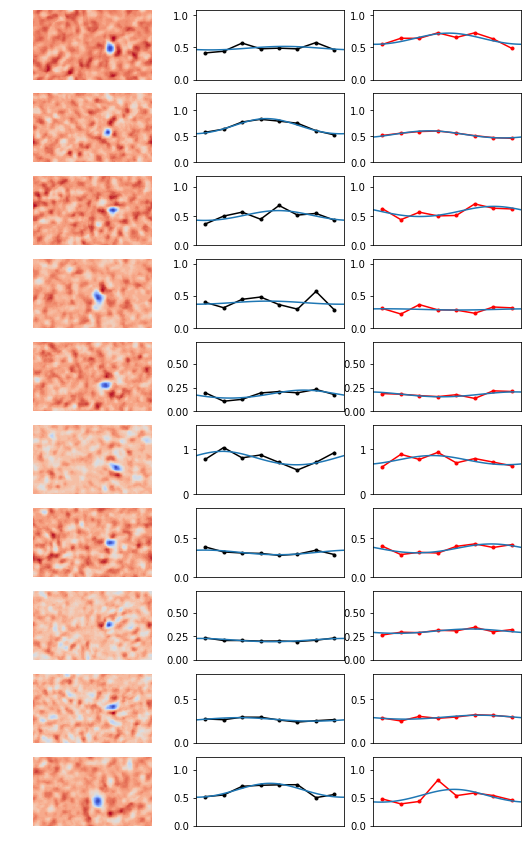

In [28]:
"""
Compute tuning curves and obtain Von Mises fits to the tuning curves
# 1. Compute tuning curves
# 2. Obtain Von Mises fits to tuning curves
"""

# # 1. Compute tuning curves
# FS_All = np.zeros([NNeu,Nbins_o,Nbins_c]) 

# for nn in range(NNeu):
#     # Initialize Tuning curves
#     TC_All = np.zeros([Nreps, Nc_V, Nbins_o, Nbins_c])

#     # Pick the RF center
#     px = np.int(RxVec[nn])
#     py = np.int(RyVec[nn])

#     # initialize tuning curve 
#     fs = np.zeros([Nbins_o, Nbins_c]) 
    
#     # Compute the tuning curves by binning 
#     for rep in range(Nreps):
#         for ii in range(Nc_V):
#             for kk in range(Nbins_o):
#                 for ll in range(Nbins_c):
#                     idx_o = np.nonzero(OMapReq[rep,ii,py,px,:] == kk)[0]
#                     idx_c = np.nonzero(CMapReq[rep,ii,py,px,:] == ll)[0]
#                     idx = np.intersect1d(idx_o,idx_c)
#                     if np.shape(idx)[0] == 0:
#                         fs[kk,ll] = 0
#                     else:
#                         fs[kk,ll] = np.mean(spikesReq[rep,ii,nn,idx])

#             TC_All[rep,ii,:,:] = fs


#     FS = np.mean(np.mean(TC_All,axis=0),axis=0)
#     FS_All[nn,:,:] = FS
    

# 2. Obtain Von Mises fits to tuning curves

AmpVec = np.zeros([NNeu,Nbins_c]) #vector of amplitudes
KVec = np.zeros([NNeu,Nbins_c]) # vector of scale factors for the neurons
ThetaVec = np.zeros([NNeu,Nbins_c]) # vector of preferred orientations

ori_set = (2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o

init_vals = [1, 1, np.pi/2]     # for [amp, scale, theta0]
lb = [0,0,0]
ub = [10,10,np.pi]

for k in range(NNeu_sel):
    for c in range(Nbins_c):
        FS = FS_All[k,:,c]
        best_vals, covar = curve_fit(vonMisesFn, ori_set, FS, p0=init_vals,bounds=(lb,ub))
        AmpVec[k,c] = best_vals[0]
        KVec[k,c] = best_vals[1]
        ThetaVec[k,c] = best_vals[2]

        
# 3. plot example RFs, tuning curves and fits to tuning curves
print('Plot has RF, tuning curve for high contrast bin (black) + fit, tuning curve for low contrast bin (red) +fit')

if plotTuningCurves:
    plt.figure()
    NK = 10
    f2, axes2 = plt.subplots(10,3,figsize=(9,15))
    for ax, k in zip(axes2,np.arange(NK)):
        theta = np.linspace(0,np.pi,100)
        #kk = -k-1
        kk = k

        rmap = response_maps[sortidx[kk]]
        ax[0].imshow(rmap[:,:,1],cmap='coolwarm')
        ax[0].axis('off')

        A = AmpVec[kk,-1]
        K = KVec[kk,-1]
        Th = ThetaVec[kk,-1]
        fsc = FS_All[kk,:,-1]
        vfit = vonMisesFn(theta,A,K,Th)
        
        vmax = fsc.max() + 0.5

        ax[1].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc,'k.-')
        ax[1].plot(np.linspace(0,np.pi,100),vfit)
        ax[1].axes.set_xlim((0,np.pi))
        ax[1].axes.set_ylim((0,vmax))
        ax[1].set_xticks([])

        A = AmpVec[kk,0]
        K = KVec[kk,0]
        Th = ThetaVec[kk,0]
        fsc = FS_All[kk,:,0]
        vfit = vonMisesFn(theta,A,K,Th)

        ax[2].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc,'r.-')
        ax[2].plot(np.linspace(0,np.pi,100),vfit)
        ax[2].axes.set_xlim((0,np.pi))
        ax[2].axes.set_ylim((0,vmax))
        ax[2].set_xticks([])

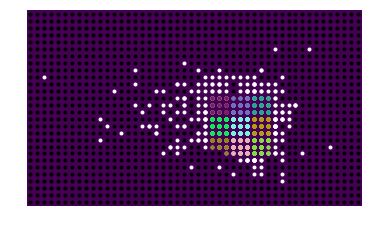

[ 36.  70.  36.  77. 125.  65.  93.  97.  72.]


In [29]:
"""
Construct the PPCs based on RF centers of the neurons
"""

X_C = np.int(np.round(RxVec.mean()))
Y_C = np.int(np.round(RyVec.mean()))

id_PPC = []

# Pick a Mx x My grid of groups(Mx and My should be odd)
# Each individual group is itself a 3x3 grid of pixels
Mx = 3
My = 3
Mxb2 = np.int((Mx-1)/2)
Myb2 = np.int((Mx-1)/2)

x0 = X_C - 1 -3*Mxb2
y0 = Y_C - 1 -3*Myb2

PopulationCenters = np.zeros([Mx*My,2])

Npops = 0

for ix in range(Mx):
    id_x = pick_indices(RxVec,x0 + ix*Mx, x0 + (ix+1)*Mx - 1)
    for iy in range(My):
        id_y = pick_indices(RyVec,y0 + iy*My, y0 + (iy+1)*My - 1)
        id_PPC.append(np.intersect1d(id_x,id_y))
        PopulationCenters[Npops,0] = x0 + ix*Mx + Mxb2
        PopulationCenters[Npops,1] = y0 + iy*My + Myb2
        Npops = Npops + 1
        
# plot the RF centers and show grouping of the PPCs
plt.figure()
plt.imshow(np.zeros([Py,Px]))
plt.plot(x.flatten(),y.flatten(),'k.')
plt.plot(RxVec,RyVec,'w.')
for i in range(Npops):
    plt.plot(RxVec[id_PPC[i]],RyVec[id_PPC[i]],color=tuple(np.random.rand(3)),marker='.',linestyle='None')
    
plt.axis('off')
plt.show()

# Find the no. of neurons in each population
NNeu_Pops = np.zeros(Npops)
for i in range(len(id_PPC)):
    NNeu_Pops[i] = len(id_PPC[i])

print(NNeu_Pops)


In [30]:
"""
Compute projections of the population responses 1. feedforward, i.e., based on stimulus, and 2. actual neural projections

1. Compute the "feedforward responses" based on the tuning curves from the selected (typically high contrast) contrast bins. 
2. Compute the cos and sin statistics for feedforward and actual neural responses
"""

# 1. Compute the "feedforward responses" based on the tuning curves from the selected contrast bins. 
# The responses are further linearly modulated by the contrasts

bin = 1
FF_Req = np.zeros(np.shape(spikesReq))

for nn in range(NNeu_sel):
    px = np.int(RxVec[nn])
    py = np.int(RyVec[nn])
    FF_Req[:,:,nn,:] = (CMapReq_U[:,:,py,px,:]/256.)*vonMisesFn(OMapReq_U[:,:,py,px,:]*np.pi/256.,AmpVec[nn,bin],KVec[nn,bin],ThetaVec[nn,bin])
    
# 2. Compute the cos and sin statistics for feedforward and actual neural responses
R_cos = np.zeros([len(id_PPC),Nreps,Nc_V,T])
R_sin = np.zeros([len(id_PPC),Nreps,Nc_V,T])

FF_cos = np.zeros([len(id_PPC),Nreps,Nc_V,T])
FF_sin = np.zeros([len(id_PPC),Nreps,Nc_V,T])

for ii in range(len(id_PPC)):
    idx = id_PPC[ii]
    ThetaPPC = expandN_dims(ThetaVec[idx,1],3)
    ThetaPPC = ThetaPPC.transpose([1,2,0,3])
    KPPC = expandN_dims(KVec[idx,1],3)
    KPPC = KPPC.transpose([1,2,0,3])
    
    # is it necessary to normalize by the number of neurons in each PPC? 
    
    if normalizeByNNeu:
        Z = len(idx)/np.mean(NNeu_Pops)
    else:
        Z = 1
    
    R_cos[ii,:,:,:] = np.sum(spikesReq[:,:,idx,:]*KPPC*np.cos(2*ThetaPPC),axis=2)/Z
    R_sin[ii,:,:,:] = np.sum(spikesReq[:,:,idx,:]*KPPC*np.sin(2*ThetaPPC),axis=2)/Z
    
    FF_cos[ii,:,:,:] = np.sum(FF_Req[:,:,idx,:]*KPPC*np.cos(2*ThetaPPC),axis=2)/Z
    FF_sin[ii,:,:,:] = np.sum(FF_Req[:,:,idx,:]*KPPC*np.sin(2*ThetaPPC),axis=2)/Z

In [31]:
"""
Computing the correlation functions
1. Autocorrelations of all signals, for each population
2. Cross-correlations between the two repeats for all signals, for each population
3. Cros-correlations between feedforward FF and neural projections R
4. Cross-correlations between populations, for all signals
"""

# First zscore all the signals. Doing this for each time-series (i.e., each 30s long condition) separately.
R_cos_z = stats.zscore(R_cos,axis=3)
R_sin_z = stats.zscore(R_sin,axis=3)
FF_cos_z = stats.zscore(FF_cos,axis=3)
FF_sin_z = stats.zscore(FF_sin,axis=3)

Ntau = 100 # no. of time lags
F = 1 # each lag corresponds to F time samples

# 1. Compute autocorrelations
AutoCorr_R_cos = np.zeros([Npops,Nreps,Nc_V,2*Ntau+1])
AutoCorr_R_sin = np.zeros([Npops,Nreps,Nc_V,2*Ntau+1])
AutoCorr_FF_cos = np.zeros([Npops,Nreps,Nc_V,2*Ntau+1])
AutoCorr_FF_sin = np.zeros([Npops,Nreps,Nc_V,2*Ntau+1])

for tau in range(-Ntau,Ntau+1):
    if tau < 0:
        AutoCorr_R_cos[:,:,:,tau+Ntau] = np.mean(R_cos_z[:,:,:,-F*tau:]*R_cos_z[:,:,:,0:T+F*tau],axis=3)
        AutoCorr_R_sin[:,:,:,tau+Ntau] = np.mean(R_sin_z[:,:,:,-F*tau:]*R_sin_z[:,:,:,0:T+F*tau],axis=3)
        AutoCorr_FF_cos[:,:,:,tau+Ntau] = np.mean(FF_cos_z[:,:,:,-F*tau:]*FF_cos_z[:,:,:,0:T+F*tau],axis=3)
        AutoCorr_FF_sin[:,:,:,tau+Ntau] = np.mean(FF_sin_z[:,:,:,-F*tau:]*FF_sin_z[:,:,:,0:T+F*tau],axis=3)
    elif tau >= 0:
        AutoCorr_R_cos[:,:,:,tau+Ntau] = np.mean(R_cos_z[:,:,:,0:T-F*tau]*R_cos_z[:,:,:,F*tau:],axis=3)
        AutoCorr_R_sin[:,:,:,tau+Ntau] = np.mean(R_sin_z[:,:,:,0:T-F*tau]*R_sin_z[:,:,:,F*tau:],axis=3)
        AutoCorr_FF_cos[:,:,:,tau+Ntau] = np.mean(FF_cos_z[:,:,:,0:T-F*tau]*FF_cos_z[:,:,:,F*tau:],axis=3)
        AutoCorr_FF_sin[:,:,:,tau+Ntau] = np.mean(FF_sin_z[:,:,:,0:T-F*tau]*FF_sin_z[:,:,:,F*tau:],axis=3)

# average across conditions and repeats
AutoCorr_R_cos = AutoCorr_R_cos.mean(axis=2).mean(axis=1)
AutoCorr_R_sin = AutoCorr_R_sin.mean(axis=2).mean(axis=1)
AutoCorr_FF_cos = AutoCorr_FF_cos.mean(axis=2).mean(axis=1)
AutoCorr_FF_sin = AutoCorr_FF_sin.mean(axis=2).mean(axis=1)


# 2. Compute cross-correlation between repeats
XCorr_R_cos = np.zeros([Npops,Nc_V,2*Ntau+1])
XCorr_R_sin = np.zeros([Npops,Nc_V,2*Ntau+1])

for tau in range(-Ntau,Ntau+1):
    if tau < 0:
        XCorr_R_cos[:,:,tau+Ntau] = np.mean(R_cos_z[:,0,:,-F*tau:]*R_cos_z[:,1,:,0:T+F*tau],axis=2)
        XCorr_R_sin[:,:,tau+Ntau] = np.mean(R_sin_z[:,0,:,-F*tau:]*R_sin_z[:,1,:,0:T+F*tau],axis=2)
    elif tau >= 0:
        XCorr_R_cos[:,:,tau+Ntau] = np.mean(R_cos_z[:,0,:,0:T-F*tau]*R_cos_z[:,1,:,F*tau:],axis=2)
        XCorr_R_sin[:,:,tau+Ntau] = np.mean(R_sin_z[:,0,:,0:T-F*tau]*R_sin_z[:,1,:,F*tau:],axis=2)

XCorr_R_cos = XCorr_R_cos.mean(axis=1)
XCorr_R_sin = XCorr_R_sin.mean(axis=1)

# 3. Compute cross-correlation between FF and R projections
XCorrCos = np.zeros([Npops,Nreps,Nc_V,2*Ntau+1])
XCorrSin = np.zeros([Npops,Nreps,Nc_V,2*Ntau+1])

for tau in range(-Ntau,Ntau+1):
    if tau < 0:
        XCorrCos[:,:,:,tau+Ntau] = np.mean(R_cos_z[:,:,:,-F*tau:]*FF_cos_z[:,:,:,0:T+F*tau],axis=3)
        XCorrSin[:,:,:,tau+Ntau] = np.mean(R_sin_z[:,:,:,-F*tau:]*FF_sin_z[:,:,:,0:T+F*tau],axis=3)
    elif tau >= 0:
        XCorrCos[:,:,:,tau+Ntau] = np.mean(R_cos_z[:,:,:,0:T-F*tau]*FF_cos_z[:,:,:,F*tau:],axis=3)
        XCorrSin[:,:,:,tau+Ntau] = np.mean(R_sin_z[:,:,:,0:T-F*tau]*FF_sin_z[:,:,:,F*tau:],axis=3)
        
XCorrCos = XCorrCos.mean(axis=2).mean(axis=1).mean(axis=0)
XCorrSin = XCorrSin.mean(axis=2).mean(axis=1).mean(axis=0)


# 4. Cross-correlations between populations, for all signals
PXCorr_R_cos = np.zeros([Npops,Npops,Nreps,Nc_V,2*Ntau+1])
PXCorr_R_sin = np.zeros([Npops,Npops,Nreps,Nc_V,2*Ntau+1])
PXCorr_FF_cos = np.zeros([Npops,Npops,Nreps,Nc_V,2*Ntau+1])
PXCorr_FF_sin = np.zeros([Npops,Npops,Nreps,Nc_V,2*Ntau+1])

for tau in range(-Ntau,Ntau+1):
    for i in range(Npops):
        for j in range(i):
            if tau < 0:
                PXCorr_R_cos[i,j,:,:,tau+Ntau] = np.mean(R_cos_z[i,:,:,-F*tau:]*R_cos_z[j,:,:,0:T+F*tau],axis=2)
                PXCorr_R_sin[i,j,:,:,tau+Ntau] = np.mean(R_sin_z[i,:,:,-F*tau:]*R_sin_z[j,:,:,0:T+F*tau],axis=2)
                PXCorr_FF_cos[i,j,:,:,tau+Ntau] = np.mean(FF_cos_z[i,:,:,-F*tau:]*FF_cos_z[j,:,:,0:T+F*tau],axis=2)
                PXCorr_FF_sin[i,j,:,:,tau+Ntau] = np.mean(FF_sin_z[i,:,:,-F*tau:]*FF_sin_z[j,:,:,0:T+F*tau],axis=2)
            elif tau >= 0:
                PXCorr_R_cos[i,j,:,:,tau+Ntau] = np.mean(R_cos_z[i,:,:,0:T-F*tau]*R_cos_z[j,:,:,F*tau:],axis=2)
                PXCorr_R_sin[i,j,:,:,tau+Ntau] = np.mean(R_sin_z[i,:,:,0:T-F*tau]*R_sin_z[j,:,:,F*tau:],axis=2)
                PXCorr_FF_cos[i,j,:,:,tau+Ntau] = np.mean(FF_cos_z[i,:,:,0:T-F*tau]*FF_cos_z[j,:,:,F*tau:],axis=2)
                PXCorr_FF_sin[i,j,:,:,tau+Ntau] = np.mean(FF_sin_z[i,:,:,0:T-F*tau]*FF_sin_z[j,:,:,F*tau:],axis=2)

PXCorr_R_cos = PXCorr_R_cos.mean(axis=3).mean(axis=2)
PXCorr_R_sin = PXCorr_R_sin.mean(axis=3).mean(axis=2)
PXCorr_FF_cos = PXCorr_FF_cos.mean(axis=3).mean(axis=2)
PXCorr_FF_sin = PXCorr_FF_sin.mean(axis=3).mean(axis=2)

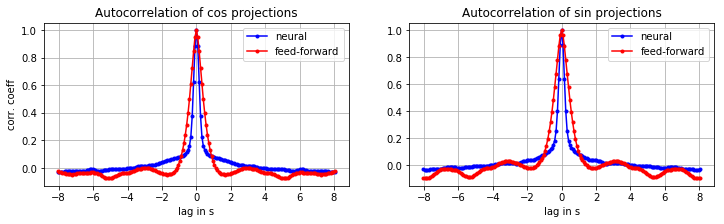

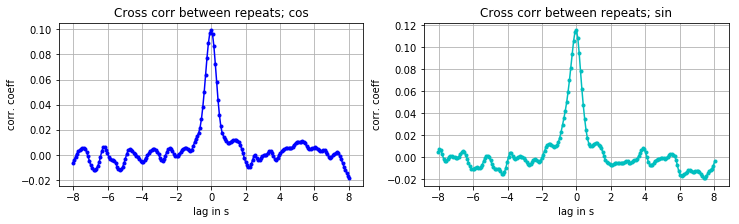

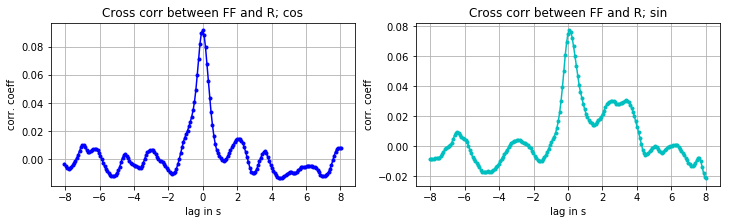

cross-correlation between R projections at different spatial locations
blue: cos, cyan: sin


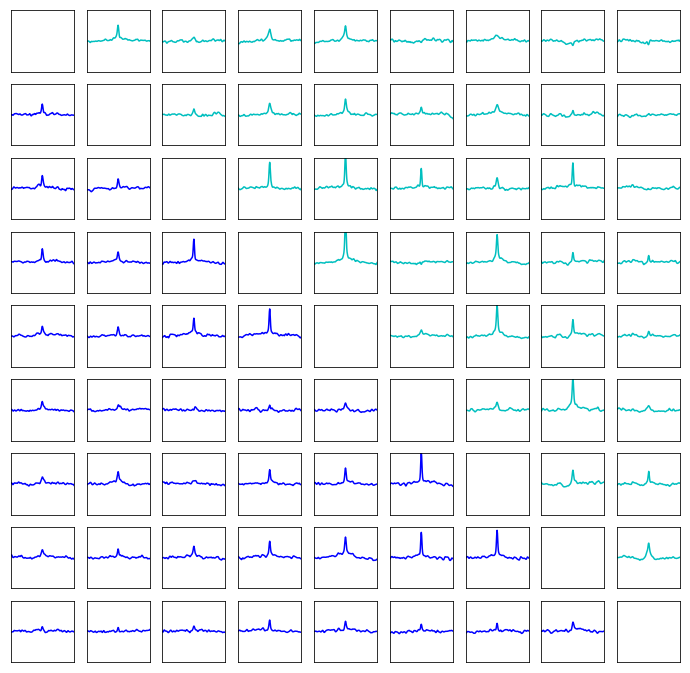

In [32]:
"""
Plot the correlation functions
"""
if plotCorrFunctions:
    
    #1. plot autocorrelation functions
    
    fig, ax = plt.subplots(1,2,figsize=(12,3))
    ax[0].plot(dt*np.arange(-Ntau,Ntau+1),AutoCorr_R_cos.mean(axis=0),'b.-')
    ax[0].plot(dt*np.arange(-Ntau,Ntau+1),AutoCorr_FF_cos.mean(axis=0),'r.-')
    ax[0].grid('on')
    ax[0].set(title='Autocorrelation of cos projections',xlabel='lag in s',ylabel='corr. coeff')
    ax[0].legend(['neural','feed-forward'])
    ax[1].plot(dt*np.arange(-Ntau,Ntau+1),AutoCorr_R_sin.mean(axis=0),'b.-')
    ax[1].plot(dt*np.arange(-Ntau,Ntau+1),AutoCorr_FF_sin.mean(axis=0),'r.-')
    ax[1].grid('on')
    ax[1].set(title='Autocorrelation of sin projections',xlabel='lag in s')
    ax[1].legend(['neural','feed-forward'])
    plt.show()
    
    #2. plot cross-correlation between repeats averaged across conditions and populations
    fig, ax = plt.subplots(1,2,figsize=(12,3))
    ax[0].plot(dt*np.arange(-Ntau,Ntau+1),XCorr_R_cos.mean(axis=0),'b.-')
    ax[0].grid('on')
    ax[0].set(title='Cross corr between repeats; cos',xlabel='lag in s',ylabel='corr. coeff')
    ax[1].plot(dt*np.arange(-Ntau,Ntau+1),XCorr_R_sin.mean(axis=0),'c.-')
    ax[1].grid('on')
    ax[1].set(title='Cross corr between repeats; sin',xlabel='lag in s',ylabel='corr. coeff')
    plt.show()
    
    #3. plot cross-correlation between FF and R projections
    fig, ax = plt.subplots(1,2,figsize=(12,3))
    ax[0].plot(dt*np.arange(-Ntau,Ntau+1),XCorrCos,'b.-')
    ax[0].grid('on')
    ax[0].set(title='Cross corr between FF and R; cos',xlabel='lag in s',ylabel='corr. coeff')
    ax[1].plot(dt*np.arange(-Ntau,Ntau+1),XCorrSin,'c.-')
    ax[1].grid('on')
    ax[1].set(title='Cross corr between FF and R; sin',xlabel='lag in s',ylabel='corr. coeff')
    plt.show()
    
    #4. plot cross-correlation between R projections at different spatial locations
    print('cross-correlation between R projections at different spatial locations')
    print('blue: cos, cyan: sin')
    fig, ax = plt.subplots(Npops,Npops,figsize=(12,12))
    for i in range(Npops):
        for j in range(i): 
            ax[i,j].plot(dt*np.arange(-Ntau,Ntau+1),PXCorr_R_cos[i,j,:],'b')
            ax[j,i].plot(dt*np.arange(-Ntau,Ntau+1),PXCorr_R_sin[i,j,:],'c')
            ax[i,j].axis([-8,8,-0.5,0.5])
            ax[j,i].axis([-8,8,-0.5,0.5])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
    for i in range(Npops):
        for j in range(Npops):
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            

In [25]:
# Save population centers
# mdict3 = {'PopulationCenters': PopulationCenters}
# fname3 = './Platinum_mouse_GNN_data/PopulationCenters' + str(key['animal_id']) + '_' + str(key['session']) + '_' + str(key['scan_idx']) + '.mat'
# savemat(fname3, mdict3)

In [26]:
# save the neural and feedforward projections
mdict = {'R_cos': R_cos, 'R_sin': R_sin, 'FF_cos': FF_cos, 'FF_sin': FF_sin}
fname = './Platinum_mouse_GNN_data/PopulationStatisticsData_'+str(key['animal_id']) + '_' + str(key['session']) + '_' + str(key['scan_idx']) + '.mat'
savemat(fname, mdict)

In [27]:
# save the neural tuning properties and PPC group indices
mdict = {'AmpVec': AmpVec, 'KVec': KVec, 'ThetaVec': ThetaVec, 'RxVec': RxVec, 'RyVec': RyVec, 'id_PPC': id_PPC}
fname = './Platinum_mouse_GNN_data/TuningProperties_'+str(key['animal_id']) + '_' + str(key['session']) + '_' + str(key['scan_idx']) + '.mat'
savemat(fname, mdict)